In [ ]:


!pip install deepchem 
!pip install transformers
!pip install openbabel
!pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 29.1 MB/s 
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.5 MB/s 
     |████████████████████████████████| 182 kB 71.3 MB/s 
     |████████████████████████████████| 7.6 MB 76.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 1.4 MB/s 
  ERROR: Failed building wheel for openbabel
  Running setup.py clean for openbabel
Failed to build openbabel
    Running setup.py install for openbabel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-mryaves9/openbabel_e125c9699e7a4ebd98b1479f1b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import string
import torch.nn as nn
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import deepchem as dc
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# from openbabel import pybel
import gensim
print(gensim.__version__)
import seaborn as sns
sns.set_theme()

4.2.0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [ ]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/models')
os.chdir('/content/drive/My Drive/models')

Mounted at /content/drive


In [ ]:
datapath = 'pruned_data.csv'
vocabpath = 'vocab.txt'

In [ ]:


datafile = pd.read_csv(datapath, index_col=False)#.drop('Unnamed: 0')
# datafile.drop(columns=datafile.columns[0], axis=1, inplace=True)
datafile.drop(columns=['atoms', 'CSD_code', 'q', 'S', 'Stoichiometry', 'MND', 'HOMO_Energy', 'LUMO_Energy', 'Electronic_E', 'Dipole_M', 'Polarizability'], axis=1, inplace=True)
# datafile['Polarizability'] = datafile['Polarizability'] / 1000
# datafile['Electronic_E'] = datafile['Electronic_E'] / 10000 
datafile

,smiles,Dispersion_E,Metal_q,HL_Gap
0,[La]1(N(c2c(cccc2C(C)C)C(C)C)[C](N1c1c(cccc1C(...,-0.239239,2.10934,0.13108
1,[La]123(O[C](C=C(O1)C(F)(F)F)C(F)(F)F)(OC(=C[C...,-0.137954,1.76650,0.14014
2,[Sc]123(OC(=C[C](O1)C(F)(F)F)C(F)(F)F)(O[C](C(...,-0.073924,1.17186,0.13865
3,n1([Y][C@@]2(C(=C(C(=C2C)C)C)C)C)c(c(c(c1C)C)C...,-0.132369,1.92642,0.10641
4,[Y]1234(N(c5c(cccc5C)C)[C]5C=CC=C(N15)N(c1c(cc...,-0.287378,1.77729,0.09247
...,...,...,...,...
70258,[Zn@@]123[N@@]([CH]c4c(OCC(=O)O2)cccc4)CCC[N@@...,-0.091175,1.19372,0.11335
70259,[Cd]123(S[C](S1)N(C)CCCC)(S[C](S2)N(C)CCCC)N1[...,-0.117090,0.83479,0.07759
70260,C12=C(c3c4c1cccc4ccc3)N(c1ccc(cc1)SC)[Zn](N2c1...,-0.107826,0.92167,0.06897
70261,[Hg](Cl)[C@@]1([Si](C)(C)C(C)(C)C)C(=C(C(=C1C)...,-0.079913,0.75218,0.09186


# Tokenize SMILES

In [ ]:
vocab = []
with open(vocabpath) as f:
    for line in f:
        vocab.append(line.rstrip())

In [ ]:
def convert_smiles_to_data(smiles, tokenizer):
    """ Convert a list of strings to a list of numpy arrays"""
    data = [None] * len(smiles)
    for i, string in enumerate(smiles):
        data[i] = tokenizer.encode(string)
        
    return data

In [ ]:
################### WARNING ####################
# Will crash runtime if gensim-version < 4.2.0 #
################################################

smiles = list(datafile['smiles'])
tokenizer = SmilesTokenizer(vocabpath)
tokenizer.encode(smiles[0])
encoded = convert_smiles_to_data(smiles, tokenizer)
datafile['encoded-smiles'] = encoded

# featurizer = dc.feat.Mol2VecFingerprint()
# features = featurizer.featurize(smiles)
# datafile['encoded-smiles'] = features
# datafile
# features

In [ ]:
# features.savetxt('mol_feats.txt')

In [ ]:
sizes = []
for a in encoded:
    sizes.append(len(a))

print('Data statistics:')
print('Number of Compounds: ', len(encoded))
print('Maximum and minimum SMILES lengths:', max(sizes), ',', min(sizes))
print('Total number of characters:', sum(sizes))
print('Vocabulary size: ', len(vocab))

sample = ''
for i in encoded[0]:
    sample +=vocab[i] 
print('Random Example SMILES:', sample)
print('Random Encoded SMILES:', encoded[0])

unique = len({x for l in encoded for x in l})
print('Unique Characters:', unique)

Data statistics:
Number of Compounds:  70263
Maximum and minimum SMILES lengths: 351 , 7
Total number of characters: 4668186
Vocabulary size:  591
Random Example SMILES: [CLS][La]1(N(c2c(cccc2C(C)C)C(C)C)[C](N1c1c(cccc1C(C)C)C(C)C)C(C)(C)C)(Cc1ccccc1)Cc1ccccc1.O1CCCC1[SEP]
Random Encoded SMILES: [12, 239, 20, 17, 23, 17, 15, 21, 15, 17, 15, 15, 15, 15, 21, 16, 17, 16, 18, 16, 18, 16, 17, 16, 18, 16, 18, 94, 17, 23, 20, 15, 20, 15, 17, 15, 15, 15, 15, 20, 16, 17, 16, 18, 16, 18, 16, 17, 16, 18, 16, 18, 16, 17, 16, 18, 17, 16, 18, 16, 18, 17, 16, 15, 20, 15, 15, 15, 15, 15, 20, 18, 16, 15, 20, 15, 15, 15, 15, 15, 20, 24, 19, 20, 16, 16, 16, 16, 20, 13]
Unique Characters: 145


In [ ]:
x = list(datafile['encoded-smiles'])
# x = features
# x = torch.from_numpy(x)
for i, smiles in enumerate(x):
    x[i] = torch.tensor(smiles, dtype=torch.float32)
x = pad_sequence(x, batch_first=True, padding_value=-1)
y = datafile.drop(columns=['encoded-smiles', 'smiles']).to_numpy()
# y = datafile.drop(columns=['smiles']).to_numpy()
y = datafile['Dispersion_E'].to_numpy()
# y = np.reshape(y, (-1, 1))

In [ ]:
y.shape

(70263,)

In [ ]:
class ModelData(Dataset):
    def __init__(self, x, y):
        
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
#         print(self.x.size()[0])
        return self.x.size()[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] 
    
d = ModelData(x, y)

<ipython-input-39-dbd0352cdd9b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [ ]:
class GRUNetwork(nn.Module):
    def __init__(self):
        super(GRUNetwork, self).__init__()
        torch.manual_seed(12345)
        self.GRU = nn.GRU(input_size=max(sizes), hidden_size=64, num_layers=2, batch_first=True, bidirectional=True, dropout=0.15)
        self.LSTM = nn.LSTM(input_size=max(sizes), hidden_size=64, num_layers=2, batch_first=True, bidirectional=True, dropout=0.15)
        self.ReLU = nn.ReLU()
        self.drop = nn.Dropout(0.25)
        self.BatchNorm1d = nn.BatchNorm1d(num_features=64)
        self.linear1 = nn.Linear(in_features=128, out_features=64)
        self.linear2 = nn.Linear(in_features=64, out_features=1)
        self.linear3 = nn.Linear(in_features=16, out_features=5)
        self.linear4 = nn.Linear(in_features=32, out_features=3)
        
    def forward(self, x):
#         x = self.embed(x)
        # h, state = self.GRU(x)
        h, state = self.LSTM(x)
        h = self.linear1(h)
        h = self.drop(h)
        h = self.ReLU(h)
        h = self.BatchNorm1d(h)
        out = self.linear2(h)
        
        return out, state

class FeedforwardNetwork(nn.Module):
    def __init__(self):
        super(FeedforwardNetwork, self).__init__()
        torch.manual_seed(12345)
        self.ReLU = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=300, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=128)
        self.linear4 = nn.Linear(in_features=128, out_features=32)
        self.linear5 = nn.Linear(in_features=32, out_features=1)

        
    def forward(self, x):
        h = self.linear1(x)
        h = self.drop(h)
        h = self.ReLU(h)
        h = self.linear2(h)
        h = self.drop(h)
        h = self.ReLU(h)
        h = self.linear3(h)
        h = self.drop(h)
        h = self.ReLU(h)
        h = self.linear4(h)
        h = self.drop(h)
        h = self.ReLU(h)
        h = self.linear5(h)
        
        
        return h
    
model = GRUNetwork()
# model = FeedforwardNetwork()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, shuffle=True)
train_set = ModelData(x_train, y_train)
val_set = ModelData(x_val, y_val)
test_set = ModelData(x_test, y_test)

<ipython-input-39-dbd0352cdd9b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [ ]:
x_val.shape

torch.Size([11242, 351])

In [ ]:
def train(model, train_set, val_set, reg_weight=1, num_epochs=10, batch_size=10, lr=0.02):
    loss_metric = 1e+10
    train_loader = DataLoader(train_set, batch_size=batch_size)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    
    loss_func = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    # opt = torch.optim.RMSprop(model.parameters(), lr=lr)
    
    history = {"train_acc": [], "train_loss": [], "val_loss": [], "val_acc": []}
    
    for i in range(num_epochs):
        epoch_train_loss = []
        epoch_val_loss = []
        for _, (x, y) in enumerate(train_loader):
            model.train()
    

            y_hat, state = model(x)
            y_hat = torch.squeeze(y_hat)
            # y_hat = model(x)
            loss = loss_func(y_hat, y) * reg_weight

            opt.zero_grad()
            loss.backward()

            opt.step()

            epoch_train_loss.append(loss.detach().numpy())
            
        with torch.no_grad():
            for _, (val_x, val_y) in enumerate(val_loader):
                val_pred, _ = model(val_x)
                val_pred = torch.squeeze(val_pred)
                # val_pred = model(val_x)
                val_loss = loss_func(val_pred, val_y) * reg_weight
                
                epoch_val_loss.append(val_loss.detach().numpy())
        
        epoch_train_loss = sum(epoch_train_loss)/len(epoch_train_loss)
        epoch_val_loss = sum(epoch_val_loss)/len(epoch_val_loss)
        
        print('Epoch', i+1, '-- Train Loss', epoch_train_loss, '-- Val Loss', epoch_val_loss)

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)

        # if (i +1) % 10 == 0:
        #   torch.save(model, "epoch_" + str(i+1) + "deep.sav")
        
        if epoch_val_loss < loss_metric:
          torch.save(model, "best_deep.sav")
          loss_metric = epoch_val_loss
    
    return model, history

In [ ]:
trained_model, history = train(model, train_set, val_set, num_epochs=50, batch_size=128, lr=0.02)

Epoch 1 -- Train Loss 0.0014621312971443826 -- Val Loss 0.0015372056619856846
Epoch 2 -- Train Loss 0.001505068249488514 -- Val Loss 0.0019340181024745107
Epoch 3 -- Train Loss 0.0017530960467411205 -- Val Loss 0.001892616509311748
Epoch 4 -- Train Loss 0.0015632588626679287 -- Val Loss 0.002033586908840913


KeyboardInterrupt: ignored

In [ ]:
# torch.save(trained_model, 'deep_211_ep150_batch32_lr001.sav')

<function matplotlib.pyplot.show(*args, **kw)>

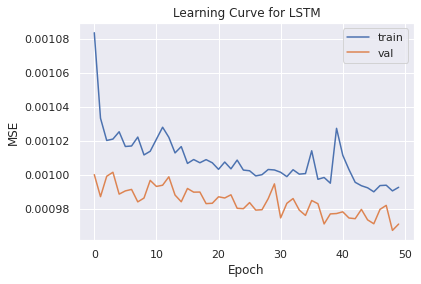

In [ ]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Learning Curve for LSTM')
# plt.savefig('training-curve.png', dpi=300)
plt.show

In [ ]:
test_model = torch.load('best_deep.sav')

In [ ]:
y_pred, _ = test_model(x_test)
test_MSE = mean_squared_error(y_test, y_pred.detach().numpy())
print('Test MSE:', test_MSE)

Test MSE: 0.0009806649278149258


Text(0.5, 1.0, 'Bidirectional GRU: Metal Charge')

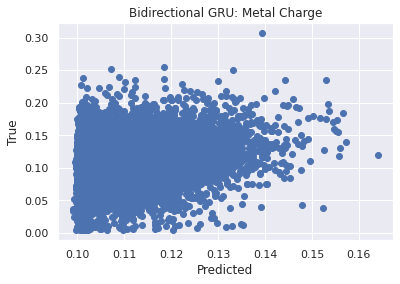

In [ ]:
plt.scatter(y_pred.detach().numpy(), y_test)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional GRU: Metal Charge')
# plt.savefig('Bidirectional_GRU_q.png', dpi=300)


0.0010776665


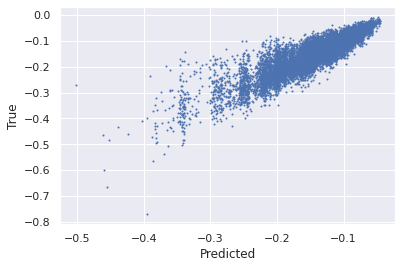

In [ ]:
def plot_predictions(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    for i, (test_x, test_y) in enumerate(loader):
        pred, _ = model(test_x)
        pred = torch.squeeze(pred)
        y_pred.append(pred.detach().numpy())
        y_true.append(test_y.detach().numpy())
    y_pred = list(np.array(y_pred,dtype=object).flatten())
    y_true = list(np.array(y_true,dtype=object).flatten())
    
    # print (y_pred)
    # Concatenate list of numpy arrays across axis 0
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Plot predictions against true values
    plt.scatter(y_pred, y_true, s=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # plt.title('Predictions vs True Values for HL_Gap')
    # plt.savefig('LSTM-HL-gap.png', dpi=300)

    return y_pred, y_true
test_loader = DataLoader(test_set, batch_size=256)
y_pred, y_true = plot_predictions(test_model, test_loader)
print(mean_squared_error(y_true, y_pred))

0.004951746123802225


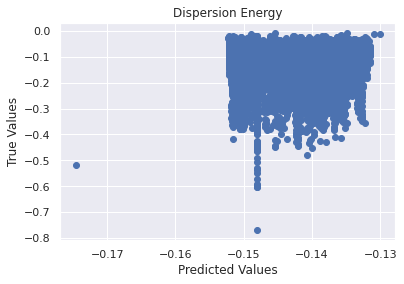

In [ ]:
plt.scatter(y_pred.detach().numpy()[:,0], y_test[:,0])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Dispersion Energy')
print(mean_squared_error(y_test[:,0], y_pred.detach().numpy()[:,0]))
# plt.axis('square')

# plt.savefig('gru-elec-e.png', dpi=300)

0.5835881098560531


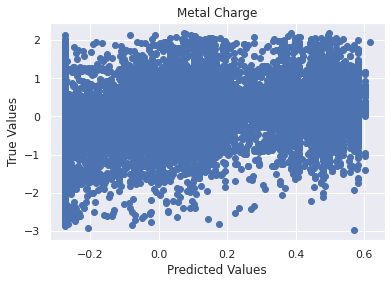

In [ ]:
plt.scatter(y_pred.detach().numpy()[:,1], y_test[:,1])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Metal Charge')
print(mean_squared_error(y_test[:,1], y_pred.detach().numpy()[:,1]))
# plt.axis('square')

# plt.savefig('gru-disp-e.png', dpi=300)

0.0011740009943882084


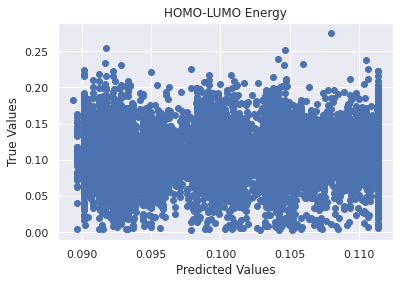

In [ ]:
plt.scatter(y_pred.detach().numpy()[:,2], y_test[:,2])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('HOMO-LUMO Energy')
print(mean_squared_error(y_test[:,2], y_pred.detach().numpy()[:,2]))
# plt.axis('square')
# plt.savefig('gru-dipole.png', dpi=300)

Text(0.5, 1.0, 'HOMO-LUMO Gap')

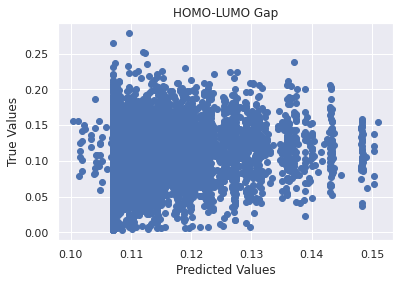

In [ ]:
plt.scatter(y_pred.detach().numpy()[:,3], y_test[:,3])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('HOMO-LUMO Gap')
# plt.axis('square')
# plt.savefig('gru-hl.png', dpi=300)

Text(0.5, 1.0, 'Polarizability')

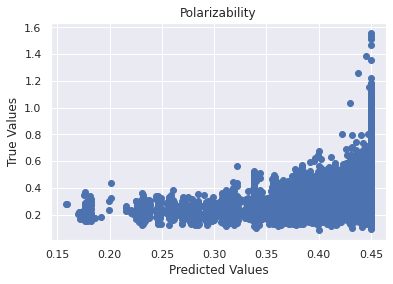

In [ ]:
plt.scatter(y_pred.detach().numpy()[:,4], y_test[:,4])
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Polarizability')
# plt.axis('square')
# plt.savefig('gru-polarizability.png', dpi=300)